# Import packages

In [1]:
import geopandas as gpd
import pandas as pd
import os
import shapely as shp
import utils
import pypsa
import pypsa.networkclustering as nc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

# Specify plotting specs

In [2]:
fs =14
fs_small = 12
mydpi = 200

# Input data

In [7]:
# Current working directory
cwd = os.getcwd()

# Input data directory
inputDataPath = os.path.join(cwd,"InputData")

# Global administrative boundaries (level 0 and 1) for Germany
DEUadm0Path = os.path.join(inputDataPath, "gadm", "DEU_adm0.shp")
DEUadm1Path = os.path.join(inputDataPath, "gadm", "DEU_adm1.shp")

# Electric grid data
busPath = os.path.join(inputDataPath, "electricGrid", 'buses.csv')
linesPath = os.path.join(inputDataPath, "electricGrid", 'lines.csv')
linksPath = os.path.join(inputDataPath, "electricGrid", 'links.csv')

# Demand data path and demand data region directory
demandPath = os.path.join(inputDataPath, "electricLoad", 'vg250.csv')
demandRegionsPath = os.path.join(inputDataPath,"electricLoad")

# Results directory of this notebook
outputPath = os.path.join(cwd, "Output")
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)

# Overlay directory and overlay shape file path
overlayPath = os.path.join(outputPath, "overlay")
if not os.path.isdir(overlayPath):
    os.makedirs(overlayPath)        
overlayShpPath = os.path.join(overlayPath, 'overlay.shp')
   
# Electricity demand directory and electricity demand data path
electricityDemandPath = os.path.join(outputPath, "electricityDemand")
if not os.path.isdir(electricityDemandPath):
    os.makedirs(electricityDemandPath)  
electricityDemandDataPath = os.path.join(electricityDemandPath, 'load_bus.xlsx')

# Overlay directory and overlay shape file path
voronoiPath = os.path.join(outputPath, "voronoi")
if not os.path.isdir(voronoiPath):
    os.makedirs(voronoiPath)        
voronoiShpPath = os.path.join(voronoiPath, 'voronoi.shp')

In [8]:
# Read electricity demand data
load_vg250 = pd.read_csv(demandPath, index_col='snapshots', parse_dates=['snapshots'], encoding='cp1252')

# Read shape data specifying the regions of interest (vg250 shape fits to demand data)
regions = utils.read_vg250_Germany_shp(shp_path=demandRegionsPath)
regions = regions.to_crs({'init': 'epsg:3035'})
DEU = gpd.read_file(DEUadm0Path).to_crs({'init': 'epsg:3035'})
DEU_1 = gpd.read_file(DEUadm1Path).to_crs({'init': 'epsg:3035'})

# Read buses
buses = pd.read_csv(busPath, index_col='name', encoding='cp1252')
buses['v_nom'] = 1  # without transformers, buses "cannot" have different voltage levels

# Read AC lines
lines = pd.read_csv(linesPath, index_col='name', 
                    encoding='cp1252')[['bus0', 'bus1', 's_nom', 'r', 'x']]
lines['r'] = lines['r'].replace(0, 1)

# Read DC links
links = pd.read_csv(linksPath, index_col='name', encoding='cp1252')

In [10]:
links

,Ref,Remarks,Total Length (Cable/Pole) (km),Type,Volt (kV),Year,bus0,bus1,p_min_pu,p_nom,type
name,,,,,,,,,,,
ALEGrO,[100],NaN,100\r\r\r\n(100/0),IGBT,320,2019.0,Visé,119,-1.0,1000.0,DC
Baltic Cable,NaN,Supplier: ABB,262\r\r\r\n(250/12),Thyr,450,1994.0,Lübeck,Kruseberg,-1.0,600.0,DC
BorWin1,[47][48][49],Supplier: ABB,200\r\r\r\n(200/0),IGBT,±150,2012.0,Diele,BorWin Alpha platform,-1.0,400.0,DC
BorWin2,[57],Supplier: Siemens,200\r\r\r\n(200/0),IGBT,±300,2015.0,Diele,BorWin Beta platform,-1.0,800.0,DC
BorWin3,NaN,Supplier: Siemens,200\r\r\r\n(200/0),IGBT,±320,2019.0,Diele,BorWin Gamma platform,-1.0,900.0,DC
BorWin5,NaN,NaN,250,NaN,NaN,2025.0,285,BorWin epsilon,-1.0,900.0,DC
DC1,NaN,NaN,NaN,NaN,NaN,2025.0,173,270,-1.0,2000.0,DC
DC2,NaN,NaN,NaN,NaN,NaN,2025.0,173,367,-1.0,2000.0,DC
DC3,NaN,NaN,NaN,NaN,NaN,2025.0,22,307,-1.0,2000.0,DC


# Create PyPSA network

In [5]:
network = pypsa.Network()
pypsa.io.import_components_from_dataframe(network, buses, 'Bus')
pypsa.io.import_components_from_dataframe(network, lines, 'Line')
pypsa.io.import_components_from_dataframe(network, links, 'Link')

# Calculate length from beeline * 1.25 (detour factor) in km
network.lines['length'] = pypsa.geo.haversine(network.buses.loc[network.lines.bus0][['x', 'y']].values,
                                              network.buses.loc[network.lines.bus1][['x', 'y']].values).diagonal() * 1.25

network.consistency_check()
network.determine_network_topology()

# Drop DC links which connect other countries to Germany
network.links = network.links.drop(["Baltic Cable", "Kontek", "BorWin2", "HelWin2", 'ALEGrO'])

# Drop buses which are neither in AC lines or DC links
for i, b in network.buses.iterrows():
    inLines = any(b.name == network.lines.bus0) or any(b.name == network.lines.bus1)
    inLinks = any(b.name == network.links.bus0) or any(b.name == network.links.bus1)
    if not (inLines or inLinks):
        print(i)
        network.buses = network.buses.drop(i)

# # Drop lines to Denmark and Czechia
#buses_ext_ix = ['97', '325', '274', '273', '203', '430', '222', 'NEW_DK_node', 'Endrup', 'Plewiska',
#                'Doetinchem', '182']

buses_ext_ix = ['97', 'Endrup', '273', '222', 'Plewiska', 'offshore_bus3', 'offshore_bus4',
                'offshore_bus5',]

for ix in buses_ext_ix:
    print(ix)
    network.buses = network.buses.drop(ix)
    if (network.lines['bus1'] == ix).any():
        ixLine = network.lines[network.lines['bus1'] == ix].index
        network.lines = network.lines.drop(ixLine)
    if (network.lines['bus0'] == ix).any():
        ixLine = network.lines[network.lines['bus0'] == ix].index
        network.lines = network.lines.drop(ixLine)

network.buses['findMe'] = range(len(network.buses))


Bjæverskov
BorWin Beta platform
HelWin Beta platform
Kruseberg
Lübeck
Visé
97
Endrup
273
222
Plewiska
offshore_bus3
offshore_bus4
offshore_bus5


# Create GeoDataFrames

In [6]:
# Buses
geometry = [shp.geometry.Point(xy) for xy in zip(network.buses.x, network.buses.y)]
crs = {'init': 'epsg:4326'}
df = network.buses.drop(['x','y'], axis=1)
buses = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
buses = buses.to_crs({'init': 'epsg:3035'})

# AC lines
lines = []
for i, l in network.lines.iterrows():
    A = buses.loc[l.bus0].geometry
    B = buses.loc[l.bus1].geometry
    lines.append(shp.geometry.LineString([A, B]))
geometry = lines
crs = {'init': 'epsg:3035'}
df = network.lines
lines = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# DC links
links = []
for i, l in network.links.iterrows():
    A = buses.loc[l.bus0].geometry
    B = buses.loc[l.bus1].geometry
    links.append(shp.geometry.LineString([A, B]))
geometry = links
crs = {'init': 'epsg:3035'}
df = network.links
links = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [7]:
links[['bus0','bus1','geometry']].to_file(os.path.join(cwd,'InputData','electricGrid','links.shp'))
lines[['bus0','bus1','geometry']].to_file(os.path.join(cwd,'InputData','electricGrid','lines.shp'))
buses.to_file(os.path.join(cwd,'InputData','electricGrid','buses.shp'))

E:\Program Files\Continuum\Anaconda3\envs\py36\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


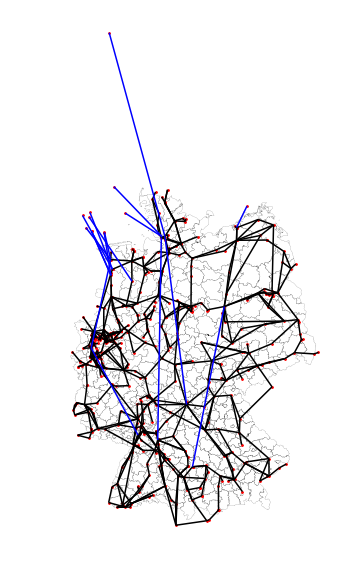

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5*2,5*2))
ax.set_aspect('equal')
rplot = regions.plot(ax=ax, facecolor='none', edgecolor="k", linewidth=0.1)
rplot.axis('off')
lnplot = lines.plot(ax=ax, color="k")
lkplot = links.plot(ax=ax, color="blue")
bplot = buses.plot(ax=ax, color="red", markersize=3)
plt.show()

# Remove links from network

In [9]:
network.determine_network_topology()

## remove small isolated networks
for sn in network.sub_networks.obj:
    subNbuses = sn.buses().index
    subNbranches = sn.branches().index

    if len(subNbuses) <= 5:
        print("Dropping Sub-Network {} because it only has {} buses".format(sn,len(subNbuses)))
        print("Dropped buses: ", subNbuses, "\n")
        for bus in subNbuses:
            network.remove("Bus",bus)
        for branch in subNbranches:
            network.remove("Line",branch[1])

    else :
        print("Keeping Sub-Network {} because it has {} buses".format(sn,len(subNbuses)))

Keeping Sub-Network SubNetwork 0 because it has 502 buses
Dropping Sub-Network SubNetwork 1 because it only has 1 buses
Dropped buses:  Index(['Baltic_1_2'], dtype='object', name='name') 

Dropping Sub-Network SubNetwork 2 because it only has 1 buses
Dropped buses:  Index(['Bentwisch'], dtype='object', name='name') 

Dropping Sub-Network SubNetwork 3 because it only has 1 buses
Dropped buses:  Index(['BorWin Alpha platform'], dtype='object', name='name') 

Dropping Sub-Network SubNetwork 4 because it only has 1 buses
Dropped buses:  Index(['BorWin Gamma platform'], dtype='object', name='name') 

Dropping Sub-Network SubNetwork 5 because it only has 1 buses
Dropped buses:  Index(['BorWin epsilon'], dtype='object', name='name') 

Dropping Sub-Network SubNetwork 6 because it only has 1 buses
Dropped buses:  Index(['Büttel'], dtype='object', name='name') 

Dropping Sub-Network SubNetwork 7 because it only has 1 buses
Dropped buses:  Index(['Diele'], dtype='object', name='name') 

Dropping 

In [10]:
# Drop buses which are neither in AC lines or DC links
for i, b in network.buses.iterrows():
    inLines = any(b.name == network.lines.bus0) or any(b.name == network.lines.bus1)
    inLinks = any(b.name == network.links.bus0) or any(b.name == network.links.bus1)
    if not (inLines or inLinks):
        print(i)
        network.buses = network.buses.drop(i)

In [11]:
network.determine_network_topology()

In [12]:
geometry = [shp.geometry.Point(xy) for xy in zip(network.buses.x, network.buses.y)]
crs = {'init': 'epsg:4326'}
df = network.buses.drop(['x','y'], axis=1)
buses = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
buses = buses.to_crs({'init': 'epsg:3035'})

In [13]:
buses.to_file(os.path.join(cwd,'InputData','electricGrid','busesReduced.shp'))
lines.loc[:,('bus0','bus1','s_nom','geometry')].to_file(os.path.join(cwd,'InputData','electricGrid','linesReduced.shp'))

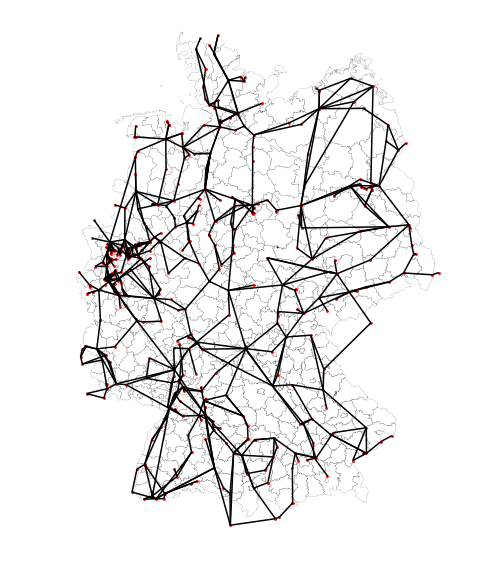

In [14]:
fig, ax = plt.subplots(1,1, figsize=(5*2,5*2))
ax.set_aspect('equal')
rplot = regions.plot(ax=ax, facecolor='none', edgecolor="k", linewidth=0.1)
rplot.axis('off')
lnplot = lines.plot(ax=ax, color="k")
bplot = buses.plot(ax=ax, color="red", markersize=3)
plt.show()

# Create voronoi regions and assign them an electricity demand


In [15]:
# overlay: intersects the voronoi regions of the buses with the vg250 regions
# to which the electricity demand is assigned to

if os.path.isfile(os.path.join(overlayShpPath)):
    # Overlay file is read
    overlay = gpd.read_file(overlayShpPath)
else:
    # Overlay file is created, coordinates of the buses are defined in epsg:4326
    overlay = utils._voronoi_overlay(network.buses, regions.to_crs({'init': 'epsg:4326'}), 'GEN')
    overlay.to_file(os.path.join(overlayShpPath))   

In [16]:
germany = load_vg250.copy()
names_dict = {'Eifelkreis Bitburg-Prüm': 'Eifelkreis-Bitburg-Prüm',
              'Kaiserslautern(Kreis)': 'Kaiserslautern',
              'Kassel(Kreis)': 'Kassel',
              'Oldenburg (Oldb)': 'Oldenburg (Oldenburg)',
              'Osnabrück(Kreis)': 'Osnabrück (Kreis)',
              'Osnabrück(Stadt)': 'Osnabrück (Stadt)',
              'Regionalverband Saarbrücken': 'Stadtverband Saarbrücken',
              'Städteregion Aachen': 'Aachen(Kreis)'}

germany.rename(columns=names_dict, inplace=True)

In [17]:
# assign load to buses (not all buses have a load)
load_bus = utils.voronoi(network.buses, regions, germany, 'GEN', overlay)
print("Time steps:", len(load_bus), "\nNumber of busses:", len(load_bus.keys()))

load_bus.columns = "bus_" + load_bus.columns
writer = pd.ExcelWriter(electricityDemandDataPath)
load_bus.to_excel(writer)
writer.save()


Distributing profiles voronoi started.

Percent: [####################] 100% Done...09453%   
Time steps: 8760 
Number of busses: 500


In [18]:
load_vg250.sum().sum()/1e6, load_bus.sum().sum()/1e6

(527.8999994087628, 527.8999994087625)

In [19]:
# Create voronoi regions
minx = min(regions.to_crs({'init': 'epsg:4326'}).bounds['minx'].min(),buses.to_crs({'init': 'epsg:4326'}).bounds['minx'].min())
miny = min(regions.to_crs({'init': 'epsg:4326'}).bounds['miny'].min(),buses.to_crs({'init': 'epsg:4326'}).bounds['miny'].min())
maxx = max(regions.to_crs({'init': 'epsg:4326'}).bounds['maxx'].max(),buses.to_crs({'init': 'epsg:4326'}).bounds['maxx'].max())
maxy = max(regions.to_crs({'init': 'epsg:4326'}).bounds['maxy'].max(),buses.to_crs({'init': 'epsg:4326'}).bounds['maxy'].max())
envelope = shp.geometry.Polygon([[minx, miny], [maxx, miny], [maxx, maxy], [minx, maxy]])

voronoi = network.buses.copy()
voronoi.loc[:, 'voronoi'] = utils.voronoi_partition_pts(voronoi[['x', 'y']].values, envelope)
voronoi = voronoi.set_geometry('voronoi')
voronoi.crs = {'init' :'epsg:4326'}
voronoi = voronoi.to_crs({'init': 'epsg:3035'})

In [20]:
# Cut the voronoi regions such that they are inside the national boundaries
intersection=voronoi.intersection(DEU.geometry.iloc[0])
voronoi_cut=voronoi.copy()
voronoi_cut.geometry=intersection
voronoi_cut["GeometryType"] = voronoi_cut.geom_type

In [21]:
# If a voronoi region is outside Germany and thus does not have an area anymore, assign it a small Polygon
# but keep the information that it was outside the country
for region, row in voronoi_cut.iterrows():
    if not (row.voronoi.type == "Polygon" or row.voronoi.type == "MultiPolygon"):
        voronoi_cut.loc[region, "GeometryType"] = 'Point'
        print(region)
        P = buses[buses.index == region].geometry.iloc[0]
        P1 = shp.geometry.Point((P.x + 10, P.y + 10))
        P2 = shp.geometry.Point((P.x + 10, P.y - 10))
        P3 = shp.geometry.Point((P.x - 10, P.y - 10))
        P4 = shp.geometry.Point((P.x - 10, P.y + 10))
        poly = shp.geometry.Polygon([[p.x, p.y] for p in [P1, P2, P3, P4]])
        voronoi_cut.loc[region,"voronoi"] = poly

357
358


In [22]:
# Save voronoi shape file
voronoi_cut["index"] = "bus_" + voronoi_cut.index
voronoi_cut[["index","Name","voronoi"]].to_file(os.path.join(voronoiPath, "voronoi.shp"))
print("Saved voronoi_cut to Shapefile")
voronoi["index"] = "bus_" + voronoi.index
voronoi[["index","Name","voronoi"]].to_file(os.path.join(voronoiPath, "voronoiFull.shp"))
print("Saved voronoi to Shapefile")

Saved voronoi_cut to Shapefile
Saved voronoi to Shapefile


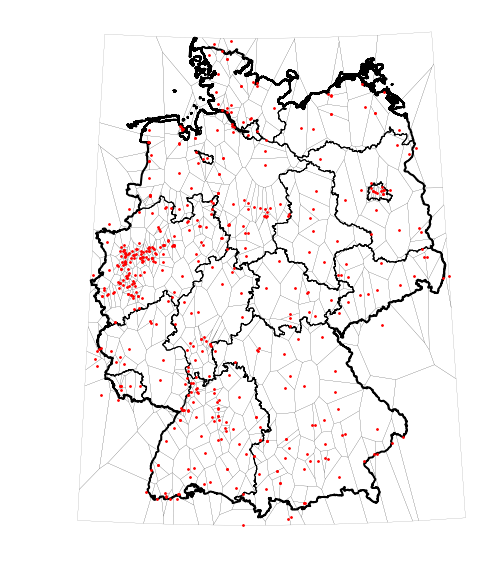

In [23]:
# Plot the created voronoi regions
fig, ax = plt.subplots(1,1, figsize=(5*2,5*2))

ax.set_aspect('equal')
DEU_1.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=1)
DEU.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=2)
voronoi.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.1)
bplot = buses.plot(ax=ax, color="red", markersize=3)
ax.axis('off')
plt.show()

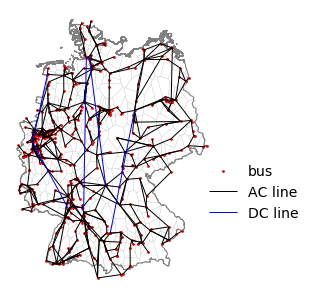

In [24]:
fileName = 'electricalGrid'
dpiLow, dpiHigh = 200, 600
fileNameLQ, fileNameHQ = fileName + 'LQ.png', fileName + 'HQ.png'

# Plot the created voronoi regions
nLinks = network.links.loc[['DC1', 'DC2', 'DC3', 'DC4', 'DC5_6']] 

# DC links to gpd
links_ = []
for i, l in nLinks.iterrows():
    A = buses.loc[l.bus0].geometry
    B = buses.loc[l.bus1].geometry
    links_.append(shp.geometry.LineString([A, B]))
geometry = links_
crs = {'init': 'epsg:3035'}
df = nLinks
links_ = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
links_["ID"] = range(len(links_))

fig, ax = plt.subplots(1,1, figsize=(3.5*1.5,3.5*1.5))

ax.set_aspect('equal')
DEU.plot(ax=ax, facecolor='none', edgecolor="grey", linewidth=1)
voronoi_cut.plot(ax=ax, facecolor='none', edgecolor="grey", linewidth=0.1)
buses.plot(ax=ax, color="red", linestyle='None', markersize=3, label='bus')
lines.plot(ax=ax, color='k', linewidth=1, label='AC line')
links_.plot(ax=ax, color='blue', linewidth=1, label='DC line')

ax.set_yticklabels([""])
ax.set_xticklabels([""])
ax.axis('off')

handles, labels = ax.get_legend_handles_labels()
index = [len(buses)-1, len(buses)+len(lines)-1, len(buses)+len(lines)+len(links_)-2]
leg = ax.legend(fontsize=14, loc=6, bbox_to_anchor=(0.9, 0.35))
leg.get_frame().set_edgecolor('white')
leg.get_frame().set_alpha(0.5)

plt.savefig(os.path.join(os.getcwd(),'Output','figures',fileNameLQ), dpi=dpiLow, transparent = True,
            bbox_inches = 'tight', pad_inches = 0)
plt.savefig(os.path.join(os.getcwd(),'Output','figures',fileNameHQ), dpi=dpiHigh, transparent = True,
            bbox_inches = 'tight', pad_inches = 0)

plt.show()

# Cluster regions

In [25]:
# Determine connecitiviy of the network
connectivity = pd.DataFrame(data=np.zeros((len(network.buses),len(network.buses))),
                            index=network.buses.index,
                            columns=network.buses.index)
for ix, line in network.lines.iterrows():
    connectivity.loc[(line.loc["bus0"],line.loc["bus1"])]=1
    connectivity.loc[(line.loc["bus1"],line.loc["bus0"])]=1

Number of clusters:  10


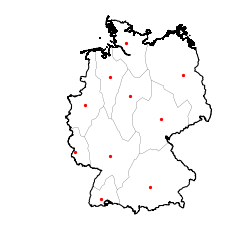

Number of clusters:  50


E:\Program Files\Continuum\Anaconda3\envs\py36\lib\site-packages\pypsa\networkclustering.py:189: RuntimeWarning: divide by zero encountered in double_scalars
  r=1./(voltage_factor/(length_factor * l['r'])).sum(),


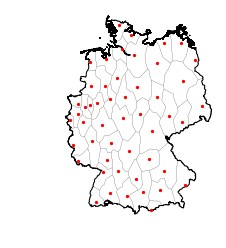

Number of clusters:  100


E:\Program Files\Continuum\Anaconda3\envs\py36\lib\site-packages\pypsa\networkclustering.py:189: RuntimeWarning: divide by zero encountered in double_scalars
  r=1./(voltage_factor/(length_factor * l['r'])).sum(),


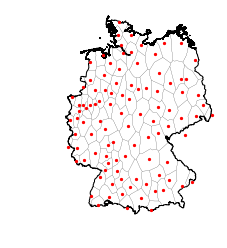

In [26]:
cRegions, cBuses = [], []
for nbRegions in [10,50,100]:
    print("Number of clusters: ", nbRegions)
    path = os.path.join(outputPath, "clusteredRegions", str(nbRegions))
    if not os.path.isdir(path):
        os.makedirs(path)        
  
    # Create bus map by using network clustering from PyPSA
    points = (network.buses.loc[network.buses.index, ["x","y"]].values)
    cluster = AgglomerativeClustering(n_clusters=nbRegions)    # , connectivity=connectivity.values
    busmap = pd.Series(data=cluster.fit_predict(points),
                       index=network.buses.index).astype(str)  
    df_busmap = pd.DataFrame(busmap).rename(columns={0:"ClusteredBus"})
    del df_busmap.index.name
    df_busmap.index = "bus_" + df_busmap.index
    df_busmap.loc[:,"ClusteredBus"] = "cluster_" + df_busmap.loc[:,"ClusteredBus"]
    # Create clusters by using network clustering from PyPSA
    clusters = nc.get_clustering_from_busmap(network, busmap)

    # Get corresponding regions
    clustered_regions = voronoi_cut.to_crs({'init': 'epsg:4326'}).dissolve(by=busmap)
    clustered_regions.crs = {'init' :'epsg:4326'}
    clustered_regions = clustered_regions.to_crs({'init': 'epsg:3035'})
    clustered_regions["index"] = "cluster_" + clustered_regions.index
    cRegions.append(clustered_regions)

    # Create geopandas data frame of the clustered buses
    geometry = [shp.geometry.Point(xy)
                for xy in zip(clusters.network.buses.x, clusters.network.buses.y)]
    crs = {'init': 'epsg:4326'}
    df = clusters.network.buses.drop(['x','y'], axis=1)
    clustered_buses = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    clustered_buses = clustered_buses.to_crs({'init': 'epsg:3035'})
    clustered_buses["index"] = "cluster_" + clustered_buses.index
    cBuses.append(clustered_buses)

    # Create geopandas data frame of the clustered lines
    clustered_lines = []
    for i, l in clusters.network.lines.iterrows():
        A = clustered_buses.loc[l.bus0].geometry
        B = clustered_buses.loc[l.bus1].geometry
        clustered_lines.append(shp.geometry.LineString([A, B]))
    geometry = clustered_lines
    crs = {'init': 'epsg:3035'}
    df = clusters.network.lines
    clustered_lines = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    clustered_lines.loc[:,"bus0"] = "cluster_" + clustered_lines.loc[:,"bus0"]
    clustered_lines.loc[:,"bus1"] = "cluster_" + clustered_lines.loc[:,"bus1"]    
        
    # Plot regions, number of regions and connections and save as png file
    fig, ax = plt.subplots(1,1, figsize=(3,4))

    ax.set_aspect('equal')
    mydpi=300
    clustered_regions.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.1)
    #rplot = voronoi_cut.plot(ax=ax, facecolor='none', edgecolor="k", linewidth=0.1)
    adm0 = DEU.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=1)
    ax.axis('off')
    #lnplot = clustered_lines.plot(ax=ax, color="k", linewidth=1)
    bplot = clustered_buses.plot(ax=ax, color="red", markersize=5)
    #buses.plot(ax=ax, color="red", markersize=3)
    #lines.plot(ax=ax, color="red", linewidth=0.1)
    #bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="0.5", alpha=0.9)
    #for bus, row in clustered_buses.iterrows():
    #    ax.annotate(s=bus, xy=(row.geometry.x, row.geometry.y), horizontalalignment='center', fontsize=6, bbox=bbox_props)
    plt.savefig(os.path.join(path,"ClusteredRegionsSimply.png"),dpi=mydpi, bbox_inches='tight')
    plt.show()

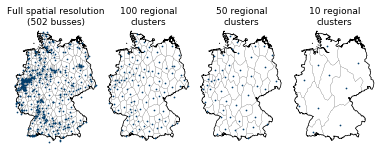

In [27]:
plt.rcParams['font.family'] = "sans-serif"
blue = (2/255,61/255,107/255)
# Plot the created voronoi regions
fs=9
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(16*0.35,16*0.24))

ax=ax1
ax.set_aspect('equal')
DEU.simplify(1000).plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.7)
voronoi_cut.simplify(1000).plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.1)
bplot = buses.plot(ax=ax, color=blue, markersize=0.5)
ax.set_yticklabels([""])
ax.set_xticklabels([""])
ax.axis('off')
bounds=voronoi.total_bounds
ax.set_xlim([bounds[0], bounds[2]])
ax.set_ylim([bounds[1]*0.998, bounds[3]])
ax.set_title('Full spatial resolution\n(502 busses)', fontsize=fs)

ax=ax2
ax.set_aspect('equal')
DEU.simplify(1000).plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.7)
cRegions[-1].simplify(1000).plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.1)
cBuses[-1].plot(ax=ax, color=blue, markersize=0.5)
ax.set_yticklabels([""])
ax.set_xticklabels([""])
ax.axis('off')
bounds=voronoi.total_bounds
ax.set_xlim([bounds[0], bounds[2]])
ax.set_ylim([bounds[1]*0.998, bounds[3]])
ax.set_title('100 regional\nclusters', fontsize=fs)

ax=ax3
ax.set_aspect('equal')
DEU.simplify(1000).plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.7)
cRegions[-2].simplify(1000).plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.1)
cBuses[-2].plot(ax=ax, color=blue, markersize=0.5)
ax.set_yticklabels([""])
ax.set_xticklabels([""])
ax.axis('off')
bounds=voronoi.total_bounds
ax.set_xlim([bounds[0], bounds[2]])
ax.set_ylim([bounds[1]*0.998, bounds[3]])
ax.set_title('50 regional\nclusters', fontsize=fs)

ax=ax4
ax.set_aspect('equal')
DEU.simplify(1000).plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.7)
cRegions[-3].simplify(1000).plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.1)
cBuses[-3].plot(ax=ax, color=blue, markersize=0.5)
ax.set_yticklabels([""])
ax.set_xticklabels([""])
ax.axis('off')
bounds=voronoi.total_bounds
ax.set_xlim([bounds[0], bounds[2]])
ax.set_ylim([bounds[1]*0.998, bounds[3]])
ax.set_title('10 regional\nclusters', fontsize=fs)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05)

mydpi=300
path = os.path.join(cwd,'Output','figures')
plt.savefig(os.path.join(path,"RegionalClustering.png"),dpi=mydpi, bbox_inches='tight')
plt.savefig(os.path.join(path,"RegionalClustering.pdf"), bbox_inches='tight')
plt.show()

Number of clusters:  10


E:\Program Files\Continuum\Anaconda3\envs\py36\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


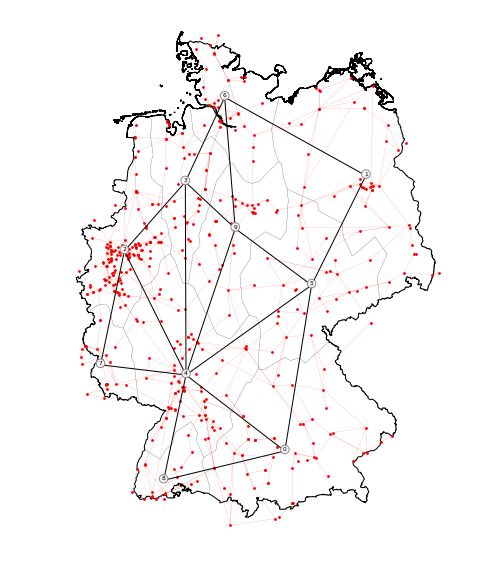

Number of clusters:  50


E:\Program Files\Continuum\Anaconda3\envs\py36\lib\site-packages\pypsa\networkclustering.py:189: RuntimeWarning: divide by zero encountered in double_scalars
  r=1./(voltage_factor/(length_factor * l['r'])).sum(),
E:\Program Files\Continuum\Anaconda3\envs\py36\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


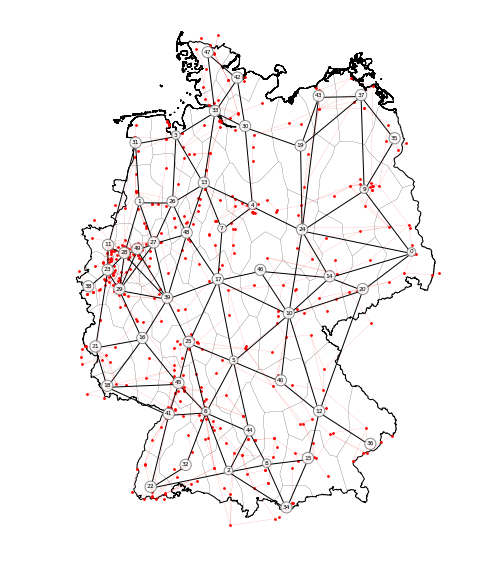

Number of clusters:  75


E:\Program Files\Continuum\Anaconda3\envs\py36\lib\site-packages\pypsa\networkclustering.py:189: RuntimeWarning: divide by zero encountered in double_scalars
  r=1./(voltage_factor/(length_factor * l['r'])).sum(),
E:\Program Files\Continuum\Anaconda3\envs\py36\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


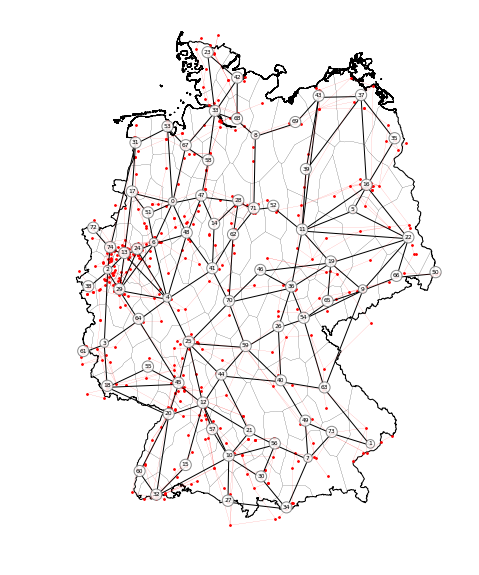

Number of clusters:  100


E:\Program Files\Continuum\Anaconda3\envs\py36\lib\site-packages\pypsa\networkclustering.py:189: RuntimeWarning: divide by zero encountered in double_scalars
  r=1./(voltage_factor/(length_factor * l['r'])).sum(),
E:\Program Files\Continuum\Anaconda3\envs\py36\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


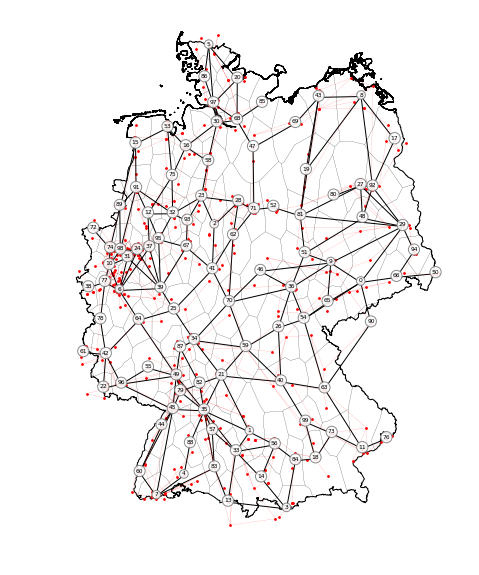

In [28]:
yHalf=DEU.to_crs({'init': 'epsg:4326'}).centroid.iloc[0].y

for nbRegions in [10,50,75,100]:
    print("Number of clusters: ", nbRegions)
    path = os.path.join(outputPath, "clusteredRegions", str(nbRegions))
    if not os.path.isdir(path):
        os.makedirs(path)
        
    shapePath = os.path.join(path, 'shapeFiles')         
    if not os.path.isdir(shapePath):
        os.makedirs(shapePath)        
    
    # Create bus map by using network clustering from PyPSA
    points = (network.buses.loc[network.buses.index, ["x","y"]].values)
    df_points = pd.DataFrame(points, columns=['x','y'])
    df_points.index = "bus_" + network.buses.index
    
    cluster = AgglomerativeClustering(n_clusters=nbRegions)    # , connectivity=connectivity.values
    busmap = pd.Series(data=cluster.fit_predict(points),
                       index=network.buses.index).astype(str) 
    if nbRegions == 2:
        # Spilt Germany in Nothern and Southern Germany based on its centroid
        data = ['1' if df_points.loc['bus_' + x,'y'] < yHalf
                else '0' for x in busmap.index]
        busmap = pd.Series(data=data, index=network.buses.index).astype(str) 
        
    df_busmap = pd.DataFrame(busmap).rename(columns={0:"ClusteredBus"})
    del df_busmap.index.name
    df_busmap.index = "bus_" + df_busmap.index
    df_busmap.loc[:,"ClusteredBus"] = "cluster_" + df_busmap.loc[:,"ClusteredBus"]
    
    writer = pd.ExcelWriter(os.path.join(os.path.join(path,'busmap.xlsx')))
    df_busmap.to_excel(writer)
    writer.save()
    
    # Get corresponding regions
    clustered_regions = voronoi_cut.to_crs({'init': 'epsg:4326'}).dissolve(by=busmap)
    clustered_regions.crs = {'init' :'epsg:4326'}
    clustered_regions = clustered_regions.to_crs({'init': 'epsg:3035'})
    clustered_regions["index"] = "cluster_" + clustered_regions.index

    if nbRegions == 1:    
        clustered_regions.loc[:,["index", "voronoi"]].to_file(os.path.join(shapePath,"clusteredRegions.shp"))
        continue
        
    # Create clusters by using network clustering from PyPSA
    clusters = nc.get_clustering_from_busmap(network, busmap)
    
    # Create geopandas data frame of the clustered buses
    geometry = [shp.geometry.Point(xy)
                for xy in zip(clusters.network.buses.x, clusters.network.buses.y)]
    crs = {'init': 'epsg:4326'}
    df = clusters.network.buses.drop(['x','y'], axis=1)
    clustered_buses = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    clustered_buses = clustered_buses.to_crs({'init': 'epsg:3035'})
    clustered_buses["index"] = "cluster_" + clustered_buses.index

    # Create geopandas data frame of the clustered lines
    clustered_lines = []
    for i, l in clusters.network.lines.iterrows():
        A = clustered_buses.loc[l.bus0].geometry
        B = clustered_buses.loc[l.bus1].geometry
        clustered_lines.append(shp.geometry.LineString([A, B]))
    geometry = clustered_lines
    crs = {'init': 'epsg:3035'}
    df = clusters.network.lines
    clustered_lines = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    clustered_lines.loc[:,"bus0"] = "cluster_" + clustered_lines.loc[:,"bus0"]
    clustered_lines.loc[:,"bus1"] = "cluster_" + clustered_lines.loc[:,"bus1"]    
    
    # Store clustered regions, buses and lines to shapefile
    clustered_buses.to_file(os.path.join(shapePath, "buses.shp"))
    clustered_lines[["bus0","bus1","s_nom","geometry","x"]].to_file(os.path.join(shapePath, "AClines.shp"))
    clustered_regions.loc[:,["index", "voronoi"]].to_file(os.path.join(shapePath,"clusteredRegions.shp"))
    
    # Write incidence, length, capacity and reactance matrix
    dfC = pd.DataFrame([], columns=['name', 'var', 'location', 'value'])
    dfC = dfC.set_index(['name', 'var', 'location'])
    
    dfL = pd.DataFrame([], columns=['name', 'var', 'location', 'value'])
    dfL = dfL.set_index(['name', 'var', 'location'])

    dfX = pd.DataFrame([], columns=['name', 'var', 'location', 'value'])
    dfX = dfX.set_index(['name', 'var', 'location'])

    for key, row in clustered_lines.iterrows():
        dfL.loc[('AC lines', 'distances', row.bus0 + '_' + row.bus1)] = \
            row.geometry.length/1000*1.4 #multiplied with a detour factor of 1.4
        dfL.loc[('AC lines', 'distances', row.bus1 + '_' + row.bus0)] = \
            row.geometry.length/1000*1.4 #multiplied with a detour factor of 1.4  
            
        dfC.loc[('AC lines', 'capacitxFix', row.bus0 + '_' + row.bus1)] = \
            row.s_nom/1000*0.7 #multiplied with a security factor of 0.7
        dfC.loc[('AC lines', 'capacitxFix', row.bus1 + '_' + row.bus0)] = \
            row.s_nom/1000*0.7 #multiplied with a security factor of 0.7
            
        dfX.loc[('AC lines', 'reactances', row.bus0 + '_' + row.bus1)] = row.x
        dfX.loc[('AC lines', 'reactances', row.bus1 + '_' + row.bus0)] = row.x  

    # Write matrices to excel files
    if not os.path.isfile(os.path.join(path, "transmissionLocSpecs.xlsx")):
        columns = ['name', 'var', 'location', 'value']
        df = pd.DataFrame(columns=columns)
        df = df.set_index(['name', 'var', 'location'])
    else:
        df = pd.read_excel(os.path.join(path, "transmissionLocSpecs.xlsx"), index_col=[0,1,2])
        df = df.drop(df[df.index.get_level_values(0) == 'AC lines'].index)
        df = df.drop(df[df.index.get_level_values(0) == 'AC lines'].index)

    df = pd.concat([df, dfC, dfL, dfX])
    df.sort_index(level=[0, 1, 2], inplace=True)

    writer = pd.ExcelWriter(os.path.join(path, "transmissionLocSpecs.xlsx"))
    df.to_excel(writer)
    writer.save()  
    
    # Plot regions, number of regions and connections and save as png file
    fig, ax = plt.subplots(1,1, figsize=(5*2,5*2))

    ax.set_aspect('equal')
    clustered_regions.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=0.1)
    #rplot = voronoi_cut.plot(ax=ax, facecolor='none', edgecolor="k", linewidth=0.1)
    adm0 = DEU.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=1)
    ax.axis('off')
    lnplot = clustered_lines.plot(ax=ax, color="k", linewidth=1)
    bplot = clustered_buses.plot(ax=ax, color="red", markersize=5)
    buses.plot(ax=ax, color="red", markersize=3)
    lines.plot(ax=ax, color="red", linewidth=0.1)
    bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="0.5", alpha=0.9)
    for bus, row in clustered_buses.iterrows():
        ax.annotate(s=bus, xy=(row.geometry.x, row.geometry.y), horizontalalignment='center', fontsize=6, bbox=bbox_props)
    plt.savefig(os.path.join(path,"ClusteredRegions.png"),dpi=mydpi, bbox_inches='tight')
    plt.show()